In [1]:
from typing import Callable

import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

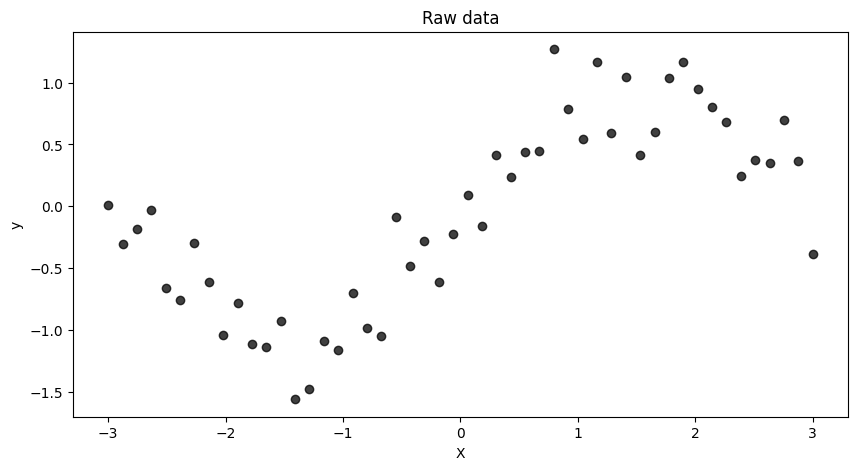

In [2]:
# Generate synthetic nonlinear data
np.random.seed(42)
X = np.linspace(-3, 3, 50)
y = np.sin(X) + 0.3 * np.random.normal(size=X.shape)  # Nonlinear function with noise
X = X.reshape(-1, 1)  # Shape (N, 1)

# Plot data and regression line
plt.figure(figsize=(10, 5))
plt.title("Raw data")
plt.scatter(X, y, color="black", alpha=0.75)
plt.xlabel("X")
plt.ylabel("y")
plt.show()
plt.close()

In [3]:
# Define Bayesian Neural Network
def model(X: jax.Array | np.ndarray, y: jax.Array | np.ndarray | None = None):
    """Bayesian Neural Network model.

    Args:
        X: Feature vector of shape (N,)
        y: Target vector of shape (N,). Defaults to None (used for predictions).
    """

    num_hidden = 5  # Small hidden layer

    # Priors for weights and biases of layer 1
    # Input dimension is (N,), Output dimension is (N, num_hidden)
    # Weight dimension is (N, num_hidden), bias dimension is (num_hidden,)
    w1 = numpyro.sample("w1", dist.Normal(0, 1).expand([1, num_hidden]))
    b1 = numpyro.sample("b1", dist.Normal(0, 1).expand([num_hidden]))

    # Priors for weights and biases of layer 2
    # Input dimension is (N, num_hidden), Output dimension is (N, 1)
    # Weight dimension is (num_hidden, 1), bias is scalar
    w2 = numpyro.sample("w2", dist.Normal(0, 1).expand([num_hidden, 1]))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))

    # Neural network forward pass
    hidden = jnp.tanh(jnp.dot(X, w1) + b1)  # Activation function
    mean = jnp.dot(hidden, w2) + b2  # Final output
    mean = mean.flatten()  # (N, 1) to (N,)

    sigma = numpyro.sample("sigma", dist.HalfCauchy(1))  # Likelihood noise

    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("obs", dist.Normal(mean, sigma), obs=y)


# Run MCMC using No U-Turn Sampler (NUTS). This is where the Bayesian magic happens,
# where we sample the posterior distribution of the parameters given the data.
# In classical ML, this would be the gradient descent algorithm (model fitting).
rng_key = random.PRNGKey(0)
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=2000)
mcmc.run(rng_key, X, y)

# Get posterior samples. This is a dictionary with the parameters as key, that is,
# "intercept", "slope", and "sigma", and the corresponding samples as values stored as
# JAX arrays (similar to Numpy).
samples = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 382.67it/s, 127 steps of size 1.42e-02. acc. prob=0.92]


In [4]:
# Define function for making predictions
def predict(
    model: Callable,
    X_new: jax.Array | np.ndarray,
    samples: dict[str, jax.Array | np.ndarray],
) -> jax.Array:
    """Predictive function to generate posterior predictive samples.

    Args:
        model: Callable function that defines the model.
        X_new: Array of new input data.
        samples: Dictionary of posterior samples.

    Returns:
        Array of posterior predictive samples of shape ``(num_samples, len(X_new))``.
    """
    predictive = Predictive(model, samples)
    pred_samples = predictive(random.PRNGKey(1), X_new)["obs"]
    return pred_samples  # Shape: (num_samples, len(X_new))


# Generate test points
X_test = jnp.linspace(-5, 5, 100).reshape(-1, 1)

# Get posterior predictive samples
y_pred_samples = predict(model, X_test, samples)

# Compute mean and 95% confidence interval.
# We aggregate over axis=0, which is the MCMC sampling axis
y_pred_mean = y_pred_samples.mean(axis=0)
y_pred_low, y_pred_high = jnp.percentile(y_pred_samples, np.array([2.5, 97.5]), axis=0)


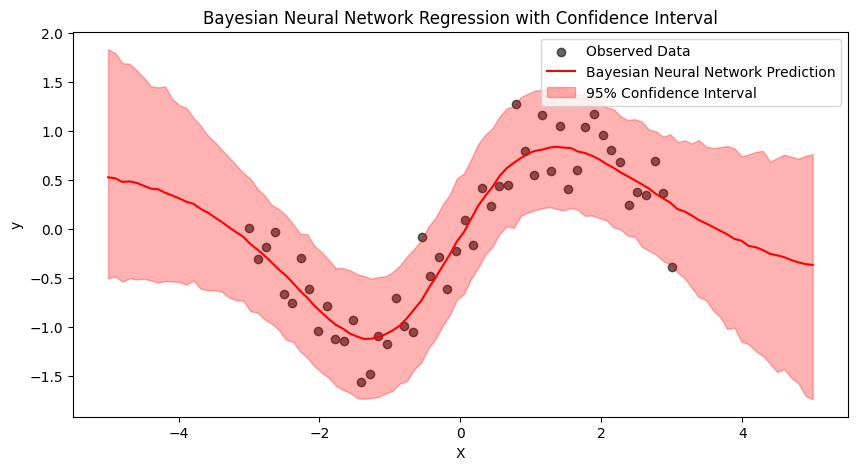

In [5]:
# Plot predictions with confidence interval
plt.figure(figsize=(10, 5))
plt.scatter(X, y, label="Observed Data", color="black", alpha=0.6)
plt.plot(X_test, y_pred_mean, label="Bayesian Neural Network Prediction", color="red")
plt.fill_between(
    X_test.flatten(),
    y_pred_low,
    y_pred_high,
    color="red",
    alpha=0.3,
    label="95% Confidence Interval",
)
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Neural Network Regression with Confidence Interval")
plt.show()